In [18]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

target = 'moved_after_2019'
idx = 'user_id'

In [20]:
df_train = df_train.set_index(idx)
df_test = df_test.set_index(idx)
df_subm = df_subm.set_index(idx)

df_exp = df_exp[df_exp['start_year_month'] < 201901]

### Education Table Preprocess

In [21]:
df_edu = df_edu[df_edu['school_name'].notnull() & df_edu['degree'].notnull()]

In [22]:
edu_conv = {
    "(?i).*(doktora|doctor|phd|ph.d).*": "phd",
    "(?i).*(yüksek|master|M.Sc|MS|MBA|M.S).*": "master",
    "(?i).*(lisans|licence|bachelor|BS|B.S|B.Sc|engineer|mühendis|mezun|graduate|licentiate).*": "graduate",
}

df_edu.loc[:, 'degree'] = df_edu.loc[:, 'degree'].replace(edu_conv, regex=True)
df_edu = df_edu[df_edu['degree'].isin(edu_conv.values())]

In [ ]:
df_edu = df_edu.drop_duplicates(['user_id', 'degree'])
df_edu = pd.pivot(df_edu, index='user_id', columns='degree', values='school_name')
df_edu.head()

### Language Table Preprocess

In [24]:
df_lang = df_lang[df_lang['language'].notnull() & df_lang['proficiency'].notnull()]

In [25]:
lang_rank = {
    'elementary': 1,
    'limited_working': 2,
    'professional_working': 3,
    'full_professional': 4,
    'native_or_bilingual': 5
}

df_lang.loc[:, 'proficiency'] = df_lang.loc[:, 'proficiency'].map(lang_rank)

C:\Users\Erdem\AppData\Local\Temp\ipykernel_11280\2046325581.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_lang.loc[:, 'proficiency'] = df_lang.loc[:, 'proficiency'].map(lang_rank)


In [26]:
lang_conv = {
    '(?i).*(ingilizce|english|englishch|englisch).*': 'english',
    '(?i).*(almanca|german|deutsch).*': 'german',
    '(?i).*(fransızca|french|français).*': 'french',
    '(?i).*(ispanyolca|spanish|español).*': 'spanish',
    '(?i).*(arapça|arabic).*': 'arabic',
    '(?i).*(rusça|russian).*': 'russian',
    '(?i).*(türkçe|turkish|türkisch).*': 'turkish',
}

df_lang['language'] = df_lang['language'].replace(lang_conv, regex=True)
df_lang = df_lang[df_lang['language'].isin(lang_conv.values())]

In [27]:
df_lang = df_lang.drop_duplicates(['user_id', 'language'])
df_lang = pd.pivot(df_lang, index='user_id', columns='language', values='proficiency')
df_lang = df_lang.fillna(0).astype(int)
df_lang.head()

language,arabic,english,french,german,russian,spanish,turkish
user_id,,,,,,,
8,0,4,1,0,0,0,5
11,0,3,0,0,0,0,5
12,0,3,0,0,0,0,5
13,0,4,0,2,0,0,0
14,0,3,0,0,0,0,5


### Skill Table Preprocess

In [28]:
used_skills = df_skill['skill'].value_counts().iloc[:60].index # we only took most common 60 skills, you can increase it

df_skill = df_skill[df_skill['skill'].isin(used_skills)]
df_skill['experience'] = True

In [29]:
df_skill = df_skill.drop_duplicates(['user_id', 'skill'])
df_skill = pd.pivot(df_skill, index='user_id', columns='skill', values='experience')
df_skill = df_skill.fillna(0).astype(int)
df_skill.head()

skill,.NET,AJAX,ASP.NET,ASP.NET MVC,Agile Methodologies,Android,AutoCAD,C,C#,C++,...,Spring Framework,T-SQL,Visual Studio,Web Development,Web Geliştirme,Web Services,XML,Yazılım Geliştirme,jQuery,İngilizce
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Experience Table Preprocess

In [30]:
df_exp = df_exp.sort_values(by=['user_id', 'start_year_month']) # we want nth function to return the last companies by date
df_new = pd.DataFrame()

In [31]:
df_exp['start_date'] = pd.to_datetime(df_exp['start_year_month'], format='%Y%m')
df_exp['end_date'] = pd.to_datetime(df_exp.groupby('user_id')['start_date'].shift(-1), errors='coerce')
df_exp['end_date'] = df_exp['end_date'].fillna(pd.to_datetime('20190101', format='%Y%m%d'))

In [32]:
df_exp['experience_duration'] = (df_exp['end_date'] - df_exp['start_date']).dt.days

In [33]:
df_new = df_exp.groupby(idx).agg(
    {'experience_duration': 'mean'}
).rename(columns={'experience_duration': 'total_duration'})

In [34]:
num_companies = df_exp.groupby('user_id')['company_id'].nunique()
total_exp_duration = df_exp.groupby('user_id')['experience_duration'].sum()
avg_exp_duration = (total_exp_duration / num_companies).fillna(0)
df_new['avg_exp_duration'] = df_exp['user_id'].map(avg_exp_duration)


In [35]:
df_new['avg_exp_duration'] = np.where(df_new['avg_exp_duration'].isna(), df_new['total_duration'], df_new['avg_exp_duration'])

In [36]:
df_new['company(1th)'] = df_exp.groupby(idx)['company_id'].nth(-1).astype(str)
df_new['company(2th)'] = df_exp.groupby(idx)['company_id'].nth(-2).astype(str)
df_new['company(3th)'] = df_exp.groupby(idx)['company_id'].nth(-3).astype(str)

df_new['company_location(1th)'] = df_exp.groupby(idx)['location'].nth(-1).astype(str)
df_new['company_location(2th)'] = df_exp.groupby(idx)['location'].nth(-2).astype(str)
df_new['company_location(3th)'] = df_exp.groupby(idx)['location'].nth(-3).astype(str)

df_new['min_exp_time'] = df_exp.groupby(idx)['start_year_month'].min()
df_new['max_exp_time'] = df_exp.groupby(idx)['start_year_month'].max()

df_new['company_count_2018'] = df_exp[df_exp['start_year_month'].gt(201712)].groupby(idx).size()
df_new['company_count_2017'] = df_exp[df_exp['start_year_month'].gt(201612)].groupby(idx).size()
df_new['company_count_2016'] = df_exp[df_exp['start_year_month'].gt(201512)].groupby(idx).size()
df_new['company_count_2015'] = df_exp[df_exp['start_year_month'].gt(201412)].groupby(idx).size()
df_new['company_count_2014'] = df_exp[df_exp['start_year_month'].gt(201312)].groupby(idx).size()
df_new['company_count_2013'] = df_exp[df_exp['start_year_month'].gt(201212)].groupby(idx).size()


In [37]:
df_exp = df_new
df_exp.head()

,total_duration,avg_exp_duration,company(1th),company(2th),company(3th),company_location(1th),company_location(2th),company_location(3th),min_exp_time,max_exp_time,company_count_2018,company_count_2017,company_count_2016,company_count_2015,company_count_2014,company_count_2013
user_id,,,,,,,,,,,,,,,,
0,2435.000000,750.666667,0,0,NaN,Visual Studio Asp.Net Developer,Serbest Çalışmalar,NaN,200509,200509,NaN,NaN,NaN,NaN,NaN,NaN
2,253.666667,2222.000000,10,7,9,"Mersin, Turkey","Elazig, Turkey","Elazig, Turkey",201612,201806,1.0,2.0,3.0,3.0,3.0,3.0
5,579.000000,818.444444,15,NaN,NaN,İstanbul,NaN,NaN,201706,201706,NaN,1.0,1.0,1.0,1.0,1.0
7,228.500000,1380.000000,20,21,21,Elazığ,Macedonia,"Istanbul, Turkey",201607,201812,1.0,3.0,4.0,4.0,4.0,4.0
10,659.666667,659.666667,26,26,27,istanbul,"Istanbul, Turkey","Elazig, Turkey",201308,201805,2.0,2.0,2.0,2.0,2.0,3.0


### Merge Tables

In [38]:
df_train[df_edu.columns]   = df_edu[df_edu.columns]
df_train[df_lang.columns]  = df_lang[df_lang.columns]
df_train[df_skill.columns] = df_skill[df_skill.columns]
df_train[df_exp.columns]   = df_exp[df_exp.columns]

df_test[df_edu.columns]   = df_edu[df_edu.columns]
df_test[df_lang.columns]  = df_lang[df_lang.columns]
df_test[df_skill.columns] = df_skill[df_skill.columns]
df_test[df_exp.columns]   = df_exp[df_exp.columns]

### Encoding

In [39]:
cat_cols = [col for col in df_test.columns if df_test[col].dtype == 'object']
num_cols = [col for col in df_test.columns if df_test[col].dtype != 'object']

In [40]:
for col in cat_cols:
    train_cats  = set(df_train[col].unique())
    test_cats   = set(df_test[col].unique())
    common_cats = set.intersection(train_cats, test_cats)
    
    df_train.loc[~df_train[col].isin(common_cats), col] = 'other'
    df_test.loc[~df_test[col].isin(common_cats), col] = 'other'

In [41]:
df_all = pd.concat([df_train, df_test], axis=0)

for col in cat_cols:
    df_all[col] = df_all[col].factorize()[0]

df_all[cat_cols] = df_all[cat_cols].astype('category')
df_all[num_cols] = df_all[num_cols].fillna(-1)

df_train = df_all.loc[df_train.index, df_train.columns]
df_test = df_all.loc[df_test.index, df_test.columns]

In [42]:

df_train['max_exp_time **2'] = df_train['max_exp_time'] **2

df_test['max_exp_time **2'] = df_test['max_exp_time'] **2


### Training

In [44]:
#Feature Importance

In [45]:
from sklearn.ensemble  import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
# initialize the model with hyperparameters
clf = RandomForestClassifier(n_estimators=700)

# fit the model on data
clf.fit(X, y)

# get feature importances
importances = clf.feature_importances_

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# print the feature importances
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

1. feature graduate (0.060479)
2. feature industry (0.050537)
3. feature total_duration (0.047960)
4. feature min_exp_time (0.046720)
5. feature location (0.046367)
6. feature company(1th) (0.039807)
7. feature avg_exp_duration (0.034980)
8. feature max_exp_time **2 (0.034214)
9. feature max_exp_time (0.034188)
10. feature company(2th) (0.028271)
11. feature master (0.027288)
12. feature company_location(1th) (0.027252)
13. feature company_location(2th) (0.021941)
14. feature company(3th) (0.020486)
15. feature company_location(3th) (0.017000)
16. feature english (0.013970)
17. feature company_count_2013 (0.010819)
18. feature german (0.010290)
19. feature company_count_2014 (0.010036)
20. feature Java (0.010024)
21. feature company_count_2015 (0.009570)
22. feature SQL (0.009451)
23. feature Python (0.009430)
24. feature company_count_2016 (0.009325)
25. feature turkish (0.009241)
26. feature C# (0.009198)
27. feature JavaScript (0.008876)
28. feature C++ (0.008780)
29. feature Micros

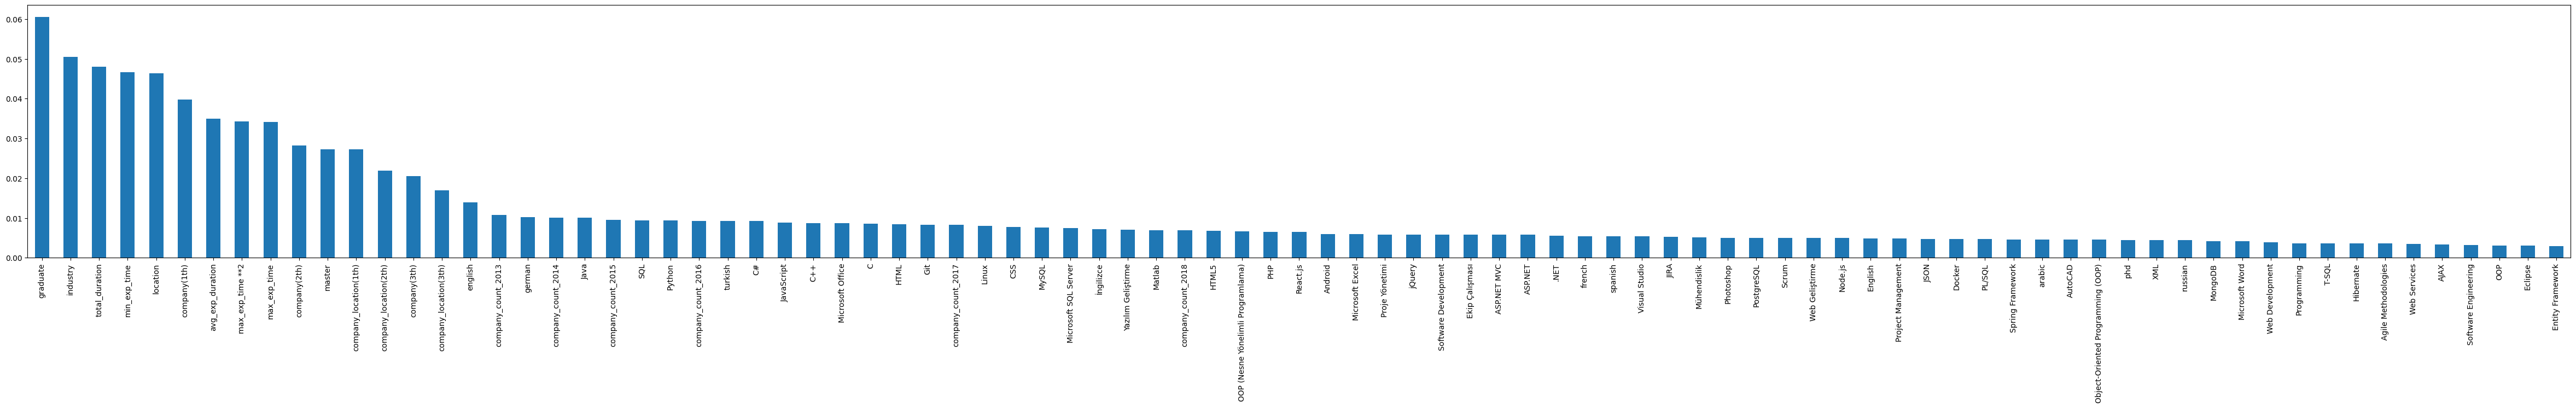

In [46]:
features = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
features.plot.bar(figsize=(60,6))
features = list(features.index)

In [50]:
df_test=df_test.drop(columns=['french','Project Management','phd','Node.js','English','PL/SQL','JSON','Spring Framework','XML',
 'Docker','Object-Oriented Programming (OOP)','AutoCAD','Microsoft Word','arabic','MongoDB','russian','Web Development','T-SQL',
 'Web Services','Hibernate','Programming','Agile Methodologies','Software Engineering','AJAX','OOP', 'Eclipse','Entity Framework'])

In [51]:
X, y = df_train.drop(columns=[target,'french','Project Management','phd','Node.js','English','PL/SQL','JSON',
 'Spring Framework','XML','Docker','Object-Oriented Programming (OOP)','AutoCAD','Microsoft Word','arabic','MongoDB','russian',
 'Web Development','T-SQL','Web Services','Hibernate','Programming','Agile Methodologies','Software Engineering','AJAX','OOP', 
 'Eclipse','Entity Framework']), df_train[target]
clf = RandomForestClassifier(n_estimators=700, class_weight='balanced_subsample', random_state=42)
cv = StratifiedKFold(shuffle=True, random_state=42)

scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print(f'Scores mean: {np.max(scores):.4f}')
print(f'Scores std: {np.std(scores):.4f}')


clf.fit(X, y)
df_subm.loc[df_test.index, target] = clf.predict(df_test)

df_subm[target] = df_subm[target].astype(int)
df_subm[target].value_counts()

KeyboardInterrupt: 

In [ ]:
df_subm

,moved_after_2019
user_id,
17449,0
33967,0
2110,0
55082,0
37165,0
...,...
32847,1
20054,0
7029,1


In [ ]:
df_subm

,moved_after_2019
user_id,
17449,0
33967,0
2110,0
55082,0
37165,0
...,...
32847,1
20054,0
7029,1
